Gets self efficacy and response efficacy score

In [1]:
library(tidyverse)
library(here)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Efficacy_scores


Attaching package: ‘lubridate’


The following object is masked from ‘package:here’:

    here


The following object is masked from ‘package:base’:

    date




Preprocessing
==============

Efficacy scores were collected in:
- every 3 days evening questionnaires (!! bug in the plateform, question was presented every day for some participants -> need to work out which and take every 3 day measures)

- baseline and followup efficacy - for EEG participants

- screening and followup questionnaire - get scores for online participants

- Participants who did the baseline and followup Efficacy score on the same survey as the every 3 days one: 
562, 477, 703, 786

In [2]:
#get filepaths

#eff_evening_filepath = here("Every3days")

cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

#read files

files_eff_eve <-dir(path=here::here("data/Every3days") , pattern = "*.csv") 
files_eff_bf <-dir(path=here::here("data/BaselineFollowup") , pattern = "*.csv") 
files_eff_online<-dir(path=here::here("data/OnlineFollowup") , pattern = "*.csv") 
files_eff_base_online<-dir(path=here::here("data/OnlineBaseline") , pattern = "baseline_eff_score.csv") # sheet with screening ID
files_study_id<-dir(path=here::here("data/OnlineBaseline") , pattern = "study_ids_online.csv") # sheet with screening_id/study_ids corresponsdence
files_qualtrics<-dir(path=here::here("data/OnlineBaseline") , pattern = "qualtrics.csv") # sheet with screening_id/study_ids corresponsdence


every3days_scores <-read.csv(here::here("data/Every3days", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


baseline_followup_eeg <-read.csv(here::here("data/BaselineFollowup", files_eff_bf), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

followup_online <-read.csv(here::here("data/OnlineFollowup", files_eff_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

baseline_online <-read.csv(here::here("data/OnlineBaseline", files_eff_base_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
study_id <-read.csv(here::here("data/OnlineBaseline",files_study_id), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
qualtrics <-read.csv(here::here("data/OnlineBaseline",files_qualtrics), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


# condition file
cond <- read_csv(cond_file)

#Associate online pp baseline efficacy score with their study id:


#select only screening ID and qualtrics ID on recruitment file
pp_ids<-baseline_online %>% select("Screening.ID", "Response.ID") 
qualtrics<-rename(qualtrics, Response.ID = ResponseId)

remove(baseline_online)

# join pp_ids with qualtrics data
baseline_online<- left_join(pp_ids, qualtrics)

# join with study id
baseline_online <- left_join(study_id, baseline_online)

# remove screening id
baseline_online<-select(baseline_online, -Screening.ID)

#rename columns 
#- questions scoring: 0 = not at all; 100 = very much

every3days_scores<-rename(every3days_scores , date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1, 
                  quit_int = Q5
                  )

every3days_scores$ID<-as.factor(every3days_scores$ID)


baseline_followup_eeg <-rename(baseline_followup_eeg, date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1
                 # quit_int = Q5
                  )

baseline_followup_eeg$ID<-as.factor(baseline_followup_eeg$ID)


followup_online<-rename(followup_online, date=EndDate, completed=Finished, 
                      ID= Q1, 
                       r_eff1 = Q88_1, r_eff2= Q88_2, 
                       s_eff1 = Q90_1, s_eff2 = Q90_2, s_eff3= Q90_3, 
                       hope=Q92_1
                       )
followup_online$ID<-as.factor(followup_online$ID)

baseline_online<-rename(baseline_online, date=EndDate, completed=Finished, 
                       ID= Study.ID, 
                       r_eff1 = Q108_1, r_eff2= Q108_2, 
                       s_eff1 = Q110_1.1, s_eff2 = Q110_2.1, s_eff3= Q110_3.1, 
                       hope=Q112_1.1
                           )

            
baseline_online$ID<-as.factor(baseline_online$ID)

Parsed with column specification:
cols(
  `Subject ID` = col_double(),
  day_msg = col_double(),
  `Starting Date` = col_character(),
  Good = col_double(),
  `Condition = Intervention` = col_double(),
  EEG = col_double(),
  Finished = col_double(),
  REMOVED = col_double(),
  Interview = col_double(),
  Notes = col_character(),
  `No Compliance` = col_double(),
  `Email reminder poor perf` = col_character(),
  eve_msg = col_double(),
  ev3days = col_double(),
  most_recent = col_date(format = ""),
  NAME = col_character(),
  EMAIL = col_character(),
  PHONE = col_character()
)

Joining, by = "Response.ID"

Joining, by = "Screening.ID"



Create one long dataset collating all data

In [3]:
# add a "session" column

every3days_scores <- add_column(every3days_scores, "type" = "every3days")
followup_online <- add_column(followup_online, "type" = "followup")
baseline_online<- add_column(baseline_online, "type" = "baseline")

get sessions for the baseline-followup dataset
  

In [4]:
# remove extra header
#baseline_followup_eeg<-tail(baseline_followup_eeg, -2)

# create session based on occurrence of ID 
baseline_followup_eeg<-baseline_followup_eeg %>% 
        #mutate(date=ymd_hms(baseline_followup_eeg$date))  %>% 
        group_by(ID)  %>%   
        mutate('type'= row_number()) %>% 
        ungroup()
        
# assign factor and recode        
baseline_followup_eeg$type<-as.factor(baseline_followup_eeg$type)        
baseline_followup_eeg$type<-recode(baseline_followup_eeg$type, '1'="baseline", '2'="followup")                            


# select only columns of interest

baseline_followup_eeg<-select(baseline_followup_eeg, ID, date, r_eff1:hope, type, completed)
every3days_scores <-select(every3days_scores, ID, date, r_eff1:hope, type, completed)
followup_online<-select(followup_online, ID, date, r_eff1:hope, type, completed)
baseline_online<-select(baseline_online, ID, date, r_eff1:hope, type, completed)

# get only completed surveys
every3days_scores<-filter(every3days_scores, completed=='True')

baseline_followup_eeg<-filter(baseline_followup_eeg, completed=='True')

followup_online<-filter(followup_online, completed=='True')
baseline_online<-filter(baseline_online, completed=='True')

Do some custom change to fit special cases

In [5]:
#---------------------------------#
# get data for the 4 pps who did the baseline and followup efficacy measure in the every3days

ID_add_to_bf <-c(562, 477, 703, 786)

tmp<- every3days_scores %>% 
  filter(ID %in% ID_add_to_bf)

tmp_bf_score <- tmp %>%  # get baseline and follow up scores - 1st and last 
  group_by(ID) %>% 
  slice(c(1, n())) %>% 
  ungroup()  

baseline_followup_eeg<-full_join(baseline_followup_eeg, tmp_bf_score)  # add to df_bf

# remove first and last measures then put back into main df dataframe, remove these ID from df before !

tmp_df <- tmp %>% 
  group_by(ID) %>% 
  slice(2:(n()-1)) %>% 
  ungroup()  


# remove those ID from df then put them back

every3days_scores<- every3days_scores %>% 
  filter(!ID %in% ID_add_to_bf )

every3days_scores<-full_join(every3days_scores, tmp_df)

rm(tmp, tmp_bf_score, tmp_df)

# get IDs of pp who did the survey every day instead of every 3 days

# add a counter for each row per ID (see 1.)
every3days_scores <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  
every3days_scores$n_day<-as.factor(every3days_scores$n_day)

get_ID_bug <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(count = row_number()) %>% 
  filter(count>9) %>% 
  distinct(ID) %>% 
  ungroup()  

  
# for those IDs, only select data from the 1, 6, 9, 12, 15, 18, 21, 24, 27 days, and rename 1:9   
days<-c(1, 6, 9, 12, 15, 18, 21, 24, 27)

# create a new dataframe combining all pps 
df9<- every3days_scores %>% 
  filter(ID %in%get_ID_bug$ID & n_day %in% days) 
  

df9$n_day<-recode_factor(df9$n_day, '1' = "1", '6'="2", '9'="3", '12' ="4", '15'="5", '18'="6", '21'="7", '24'="8", '27'="9")

tmp <- every3days_scores %>% 
filter(!ID %in% (get_ID_bug$ID) )

df9<- rbind(df9, tmp)

# create n_day column for baseline and followup
followup_online <- followup_online %>% mutate(n_day = '10')

baseline_online <- baseline_online %>% mutate(n_day = '0')

baseline_followup_eeg<-baseline_followup_eeg %>% 
    mutate(n_day=ifelse(type=='baseline', '0', '10'))
    

baseline_online<-filter(baseline_online, completed=='True')

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”
Warning message:
“Column `type` joining factor and character vector, coercing into character vector”
Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")



In [6]:
# remove extra every 3 days rows
baseline_followup_eeg<-baseline_followup_eeg %>% filter(type=='baseline'|type=='followup')

In [7]:
eff_scores<-bind_rows(baseline_followup_eeg, df9)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [8]:

tmp<-bind_rows(eff_scores, followup_online) 

tmp2<- bind_rows(tmp, baseline_online)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [9]:
remove(eff_scores)
eff_scores<-tmp2

In [10]:
eff_scores<-tail(eff_scores, -2)
eff_scores$ID<-as.factor(eff_scores$ID)
eff_scores$type<-as.factor(eff_scores$type)

eff_scores %>% 
        group_by(ID)  %>%   
        mutate(check= row_number()) %>% 
        ungroup()
        

ID,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day,check
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
763,2019-10-09 11:24:43,100,51,20,20,51,20,baseline,True,0,1
507,2019-10-10 10:29:17,99,100,45,3,11,40,baseline,True,0,1
388,2019-10-10 13:52:45,45,21,11,21,80,34,baseline,True,0,1
428,2019-10-14 10:01:58,60,61,19,2,5,1,baseline,True,0,1
375,2019-10-14 15:20:03,100,50,0,0,30,11,baseline,True,0,1
747,2019-10-16 10:24:59,49,62,18,12,72,41,baseline,True,0,1
477,2019-10-22 11:09:56,100,80,20,1,75,15,baseline,True,0,1
729,2019-10-22 13:21:12,67,31,15,5,55,18,baseline,True,0,1
562,2019-10-23 16:51:53,61,38,28,10,80,44,baseline,True,0,1


In [ ]:
eff_scores

Create one big dataframe assembling all the others

In [11]:
# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", condition = "Condition = Intervention", removed= "REMOVED")
cond$ID<-as.factor(cond$ID)

In [ ]:
#get the experiment condition file with all pp IDs only
#cond_sml<-cond %>% select(ID, condition)

In [12]:
eff_scores$ID<-as.factor(eff_scores$ID)

In [ ]:
write_csv(eff_scores, "eff_scores.csv")

In [ ]:
write_csv(cond_sml, "cond_sml.csv")

In [13]:
toto<-full_join(cond, eff_scores)

Joining, by = "ID"

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”


In [ ]:

# merge cond and eff files to get information about participants condition
#eff_scores<-inner_join(cond,eff_scores, by= 'ID')

In [14]:
remove(eff_scores)
eff_scores<-toto

In [ ]:
colnames(eff_scores)

In [15]:
eff_scores$type


[1] every3days every3days every3days every3days every3days every3days
   [7] every3days every3days followup   baseline   baseline   every3days
  [13] every3days every3days every3days every3days every3days every3days
  [19] every3days every3days every3days every3days every3days followup  
  [25] baseline   every3days every3days every3days every3days every3days
  [31] every3days every3days every3days every3days followup   every3days
  [37] every3days every3days every3days every3days every3days followup  
  [43] baseline   every3days every3days every3days every3days every3days
  [49] followup   baseline   followup   every3days every3days every3days
  [55] every3days every3days every3days every3days every3days every3days
  [61] baseline   followup   every3days every3days every3days every3days
  [67] every3days every3days every3days every3days every3days every3days
  [73] every3days every3days every3days followup   baseline   every3days
  [79] every3days every3days every3days every3days every3days followup  
  [85] baseline   every3days every3days every3days every3days every3days
  [91] every3days every3days every3days followup   every3days every3days
  [97] every3days every3days every3days every3days every3days every3days
 [103] every3days followup   every3days every3days every3days every3days
 [109] every3days every3days every3days every3days every3days every3days
 [115] every3days every3days every3days every3days every3days every3days
 [121] every3days every3days every3days every3days every3days every3days
 [127] every3days followup   baseline   every3days every3days every3days
 [133] every3days every3days every3days every3days every3days followup  
 [139] baseline   every3days every3days every3days every3days every3days
 [145] every3days every3days every3days followup   baseline   every3days
 [151] every3days every3days every3days every3days every3days every3days
 [157] every3days every3days followup   every3days every3days every3days
 [163] every3days every3days followup   every3days every3days every3days
 [169] every3days every3days every3days every3days every3days every3days
 [175] baseline   every3days every3days every3days every3days every3days
 [181] every3days every3days every3days baseline   followup   every3days
 [187] every3days every3days every3days every3days every3days every3days
 [193] every3days every3days every3days every3days every3days every3days
 [199] every3days followup   baseline   every3days every3days every3days
 [205] every3days every3days every3days every3days every3days followup  
 [211] baseline   every3days every3days every3days every3days every3days
 [217] every3days every3days every3days followup   baseline   every3days
 [223] every3days every3days every3days every3days every3days every3days
 [229] followup   every3days every3days every3days every3days every3days
 [235] every3days every3days every3days every3days followup   every3days
 [241] every3days every3days every3days every3days every3days every3days
 [247] every3days every3days every3days every3days every3days every3days
 [253] every3days every3days every3days every3days every3days every3days
 [259] every3days every3days every3days baseline   every3days every3days
 [265] every3days every3days every3days every3days every3days every3days
 [271] followup   every3days every3days every3days every3days every3days
 [277] baseline   followup   every3days every3days every3days every3days
 [283] every3days every3days every3days baseline   followup   every3days
 [289] every3days every3days every3days every3days every3days every3days
 [295] baseline   followup   every3days every3days every3days every3days
 [301] every3days every3days every3days every3days every3days every3days
 [307] every3days every3days every3days every3days every3days every3days
 [313] followup   baseline   every3days every3days every3days every3days
 [319] every3days every3days followup   baseline   every3days every3days
 [325] every3days every3days every3days every3days every3days

In [16]:
#recode condition to human names

eff_scores$condition<-recode(eff_scores$condition, '0' = "control", '1' = "intervention")


#Replace missing values and keep only participants who were not removed
eff_scores$removed<-eff_scores$removed %>% replace(is.na(.), 0)

Filter participants based on survey completion criteria

In [17]:
#filter to keep participants not removed
eff_scores<-eff_scores%>%filter(removed == 0)

In [ ]:
# filter to keep participants who did at least 80% of surveys
eff_scores<-eff_scores%>%filter(Good == 1)

Do a check of for missing values in the data


In [18]:
missing.values <- eff_scores %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing==T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


In [19]:
missing.values

key,num.missing
<chr>,<int>
Interview,1420
Email reminder poor perf,1401
No Compliance,1335
EMAIL,1193
NAME,1193
PHONE,1193
Notes,1112
Finished,326
ev3days,84


Look at why we have condition with missing values


In [20]:
which(is.na(eff_scores$condition))

[1] 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464
[16] 1465

In [21]:
# remove these lines 

eff_scores<-drop_na(eff_scores, condition)

In [22]:
df<-eff_scores


 Compute response and self efficacy scores:
--------------------------------------------

get the mean of all individual scores in each condition for each day:

- define days 1-2-3 etc.
- check for those pp who did baseline and followup (IDs 562, 477, 703, 786)
- find participants with a maximum of 9 n_day
- find participants with more than 9 n_day entries
- take only only every 3 days: 1, 6, 9, 12, 15, 18, 21

create new dataset:  
- count how many of each day per condition


In [23]:
# transform the columns for response and self efficacy that were charactuers in numeric tyoe           
df <-df %>% mutate_each(funs(as.numeric), -ID,  -date, -condition, -type) 




Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [24]:
df<-select(df, -'removed', -'Finished', -'Interview', -'Notes', -"completed" )

In [25]:
df<-select(df, -'Starting Date', -'day_msg',  -'No Compliance', -'Email reminder poor perf', -'eve_msg', -'ev3days',  -'most_recent', -'NAME', -'EMAIL', -'PHONE')

In [ ]:
colnames(df)

In [26]:
# pass n_days as factor and recode day 0 and 10
df$n_day<-as.factor(df$n_day)

df$n_day<-recode(df$n_day, '0'= 'baseline', '10'='follow-up' )

count how many of each day per condition

Warning message:
“Factor `n_day` contains implicit NA, consider using `forcats::fct_explicit_na`”
Saving 6.67 x 6.67 in image



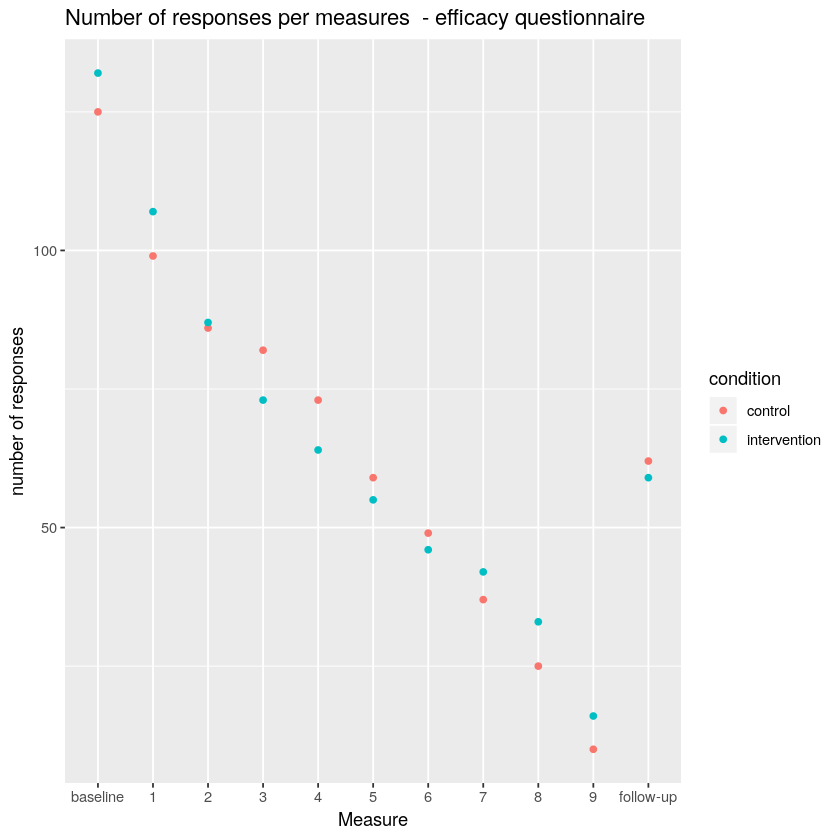

In [27]:
n_rep <- df %>% group_by(condition, n_day) %>%
 summarize(count=n()) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()


# plot
ggplot(data= n_rep, aes(x = n_day, y=count)) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Number of responses per measures  - efficacy questionnaire")+
  xlab('Measure')+ ylab('number of responses')+ 
 ggsave('nresp_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

Work on mean scores

In [28]:
# compute total score for each measure for each day and each participant

df <- df %>% group_by(ID, n_day) %>% 
  mutate(total_re= sum(r_eff1, r_eff2), 
         total_se= sum(s_eff1, s_eff2, s_eff3)
         ) %>% 
    ungroup()
    

Warning message:
“Factor `n_day` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `n_day` contains implicit NA, consider using `forcats::fct_explicit_na`”


In [29]:
# take the mean of each (resp and self) item for each day for each pp

df<- df %>% 
         mutate(mean_re= rowMeans(select(., c('r_eff1','r_eff2')), na.rm=TRUE) , 
         mean_se= rowMeans(select(., c('s_eff1', 's_eff2', 's_eff3')), na.rm=TRUE), 
         mean_hope= rowMeans(select(., c('hope')), na.rm=TRUE)        
         ) 
    

In [ ]:
df

In [30]:
df2<-select(df, -"r_eff1", -"r_eff2", -"s_eff1", -"s_eff2", -"s_eff3")

In [31]:
df2<- rename(df2, total_hope=hope)

In [32]:
df2<-select(df2, -'Good', -'EEG', -'date')

In [33]:
head(df2)

ID,condition,total_hope,type,n_day,total_re,total_se,mean_re,mean_se,mean_hope
<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
702,intervention,73,every3days,1,140,210,70,70.00000,73
702,intervention,76,every3days,2,200,214,100,71.33333,76
702,intervention,75,every3days,3,152,257,76,85.66667,75
702,intervention,76,every3days,4,162,208,81,69.33333,76
702,intervention,80,every3days,5,170,266,85,88.66667,80
702,intervention,84,every3days,6,184,271,92,90.33333,84


In [34]:
# turn df into long format 
df2_long<-df2 %>% 
  pivot_longer(
    -c('ID', 'condition','type', 'n_day'),  
    names_to = c(".value", "score"), 
    names_sep = "_", 
    values_drop_na = TRUE
  )

In [ ]:
df2_long

In [35]:
# compute summary statistics per condition per day for each score
summary_df2 <- df2_long %>%
  group_by(condition, n_day, score) %>%
  summarise(mean.total = mean(mean),
            sd.total= sd(mean), count = n(),
            se.mean = sd.total/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean)

In [36]:
summary_df2

condition,n_day,score,mean.total,sd.total,count,se.mean,ci.mean
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,baseline,hope,35.97059,27.06817,68,3.282497,-0.2066073
control,baseline,re,59.34559,23.82935,68,2.889733,-0.1818859
control,baseline,se,35.55637,25.16107,68,3.051228,-0.1920507
control,1,hope,39.25253,25.69418,99,2.582362,-0.1623468
control,1,re,65.88384,22.01795,99,2.212887,-0.1391188
control,1,se,39.76768,25.30120,99,2.542866,-0.1598638
control,2,hope,38.88372,24.29835,86,2.620159,-0.1647876
control,2,re,68.34302,23.15882,86,2.497280,-0.1570594
control,2,se,41.17442,23.28133,86,2.510490,-0.1578903



- 3. Compute mean response and self efficacy score for each day for each pp

- 4. plot
!!! different number of data points per paricipant !!!

# test plot

https://stackoverflow.com/questions/55262229/how-to-use-geom-errorbar-with-facet-wrap-in-ggplot2

In [ ]:
# IGNORE !!!

# compute mean total of response and self efficacy score for each day for each condition
#m_scores <- df %>% group_by(condition, n_day) %>% 
#  summarise(mean_re= mean(total_re,na.rm=TRUE), 
#            mean_se=mean(total_se, na.rm=TRUE), 
#            mean_hope = mean(hope, na.rm=TRUE), 
#           sd_re= sd(total_re,na.rm=TRUE), 
#           sd_se=sd(total_se, na.rm=TRUE), 
#            sd_hope = sd(hope, na.rm=TRUE), 
#             n=n()       
#           ) %>% 
#   mutate(se_re = sd_re/sqrt(n), 
#         se_se = sd_se/sqrt(n), 
#         se_hope = sd_hope/sqrt(n), 
 #         ci_re = qt(1-(1-0.95/2),n-1)*se_re, 
 #        ci_se = qt(1-(1-0.95/2),n-1)*se_se, 
 #        ci_hope = qt(1-(1-0.95/2),n-1)*se_hope
 #        ) %>% 
 #   ungroup()

#m_scores <- left_join(m_scores, n_rep)

In [ ]:
#write_csv(m_scores, "summary_stats.csv")

Plot response and self efficacy scores

In [ ]:
#m_scores %>% gather("type", "score", 3:4 ) %>% 
#  ggplot(data=., mapping=aes(x= n_day, y=score)) +
#         geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+
#        facet_wrap(~type)+
  #geom_errorbar(aes(ymin=score-ci, ymax=score+ci))+  
#  geom_smooth(se=FALSE)+
#  ggtitle("Mean scores for response and self efficacy per day per condition")
  
#  ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [37]:
test_eff<-summary_df2 %>% 
        filter(score=="re" | score=="se") 

Saving 6.67 x 6.67 in image



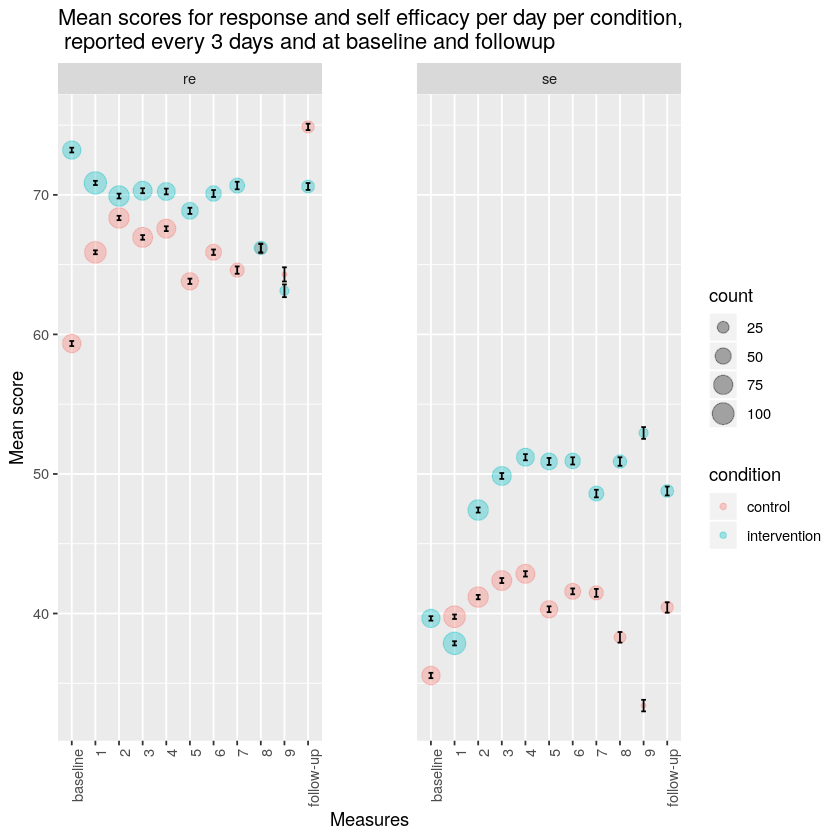

In [38]:
gs1 <- ggplot(test_eff, aes(x=n_day, y=mean.total)) + 
       geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       facet_wrap(~score)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
    ggtitle("Mean scores for response and self efficacy per day per condition,\n reported every 3 days and at baseline and followup")
gs1 + theme(panel.spacing.x=unit(2, "cm"),panel.spacing.y=unit(1, "lines")) +
 theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave('efficacy_scores_v2.jpg', plot =last_plot(), dpi =300, path= save_figure)

In [ ]:
?options


Seems like scores were quite high to start with for response efficacy, maybe a plateau effect while self efficacy scores were lower at baseline

Plot hope score

In [39]:
test_hope<-summary_df2 %>% 
        filter(score=="hope")  

In [ ]:
test_hope

Saving 6.67 x 6.67 in image



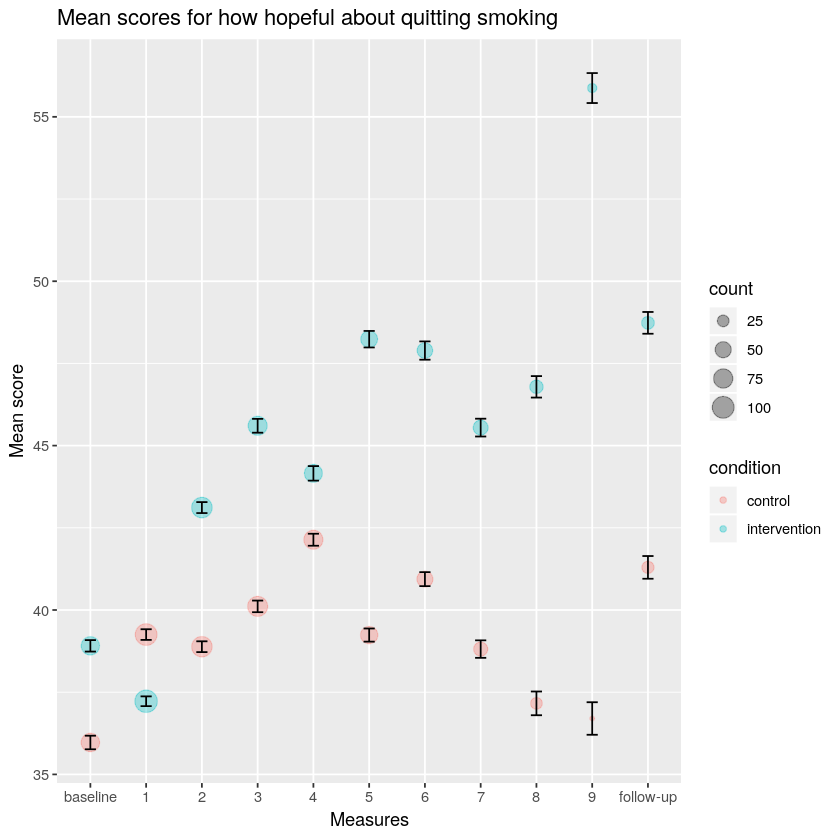

In [41]:

ggplot(data=test_hope, mapping=aes(x= n_day, y=mean.total)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
   ggtitle("Mean scores for how hopeful about quitting smoking")

  ggsave('hope_scores_v2.jpg', plot =last_plot(), dpi =300, path= save_figure)


Make raincloud plots

In [42]:
library(cowplot)
library(readr)

source("~/Documents/RainCloudPlots/tutorial_R/R_rainclouds.R")
source("~/Documents/RainCloudPlots/tutorial_R/summarySE.R")

theme_set(theme_cowplot())


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [ ]:
packages <- c("ggplot2", "dplyr", "lavaan", "plyr", "cowplot", "rmarkdown",
"readr", "caTools", "bitops")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
install.packages(setdiff(packages, rownames(installed.packages())))
}

In [43]:
df3<-df2

In [45]:
which(is.na(df3$n_day))

[1] 1171 1312 1357 1392 1399 1402 1403 1404 1405 1409 1410 1413 1414 1422 1423
[16] 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435 1436

In [46]:
df3<-drop_na(df3, n_day)

In [62]:
p12 <- ggplot(df3, aes(x = n_day, y = mean_se, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = mean_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = mean_se,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Self-efficacy score") +
  coord_flip()

In [59]:
cbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Warning message:
“Removed 186 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 186 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 186 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 186 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 186 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 186 rows containing missing values (geom_point).”


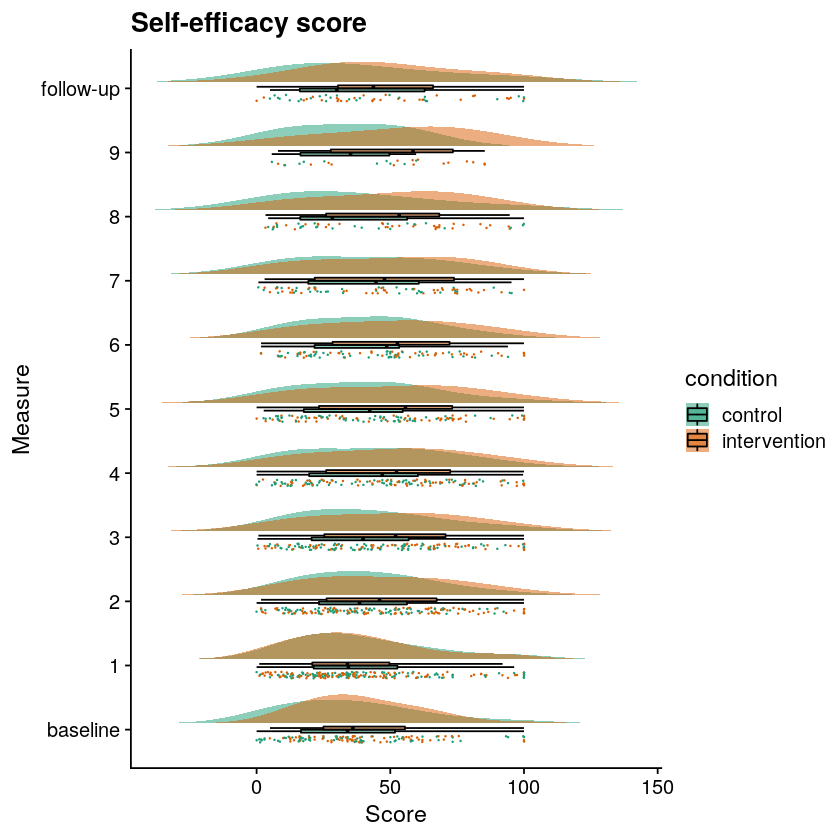

In [63]:
p12

ggsave('raincloud_self_eff_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


Warning message:
“Removed 186 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 186 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 186 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 186 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 186 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 186 rows containing missing values (geom_point).”


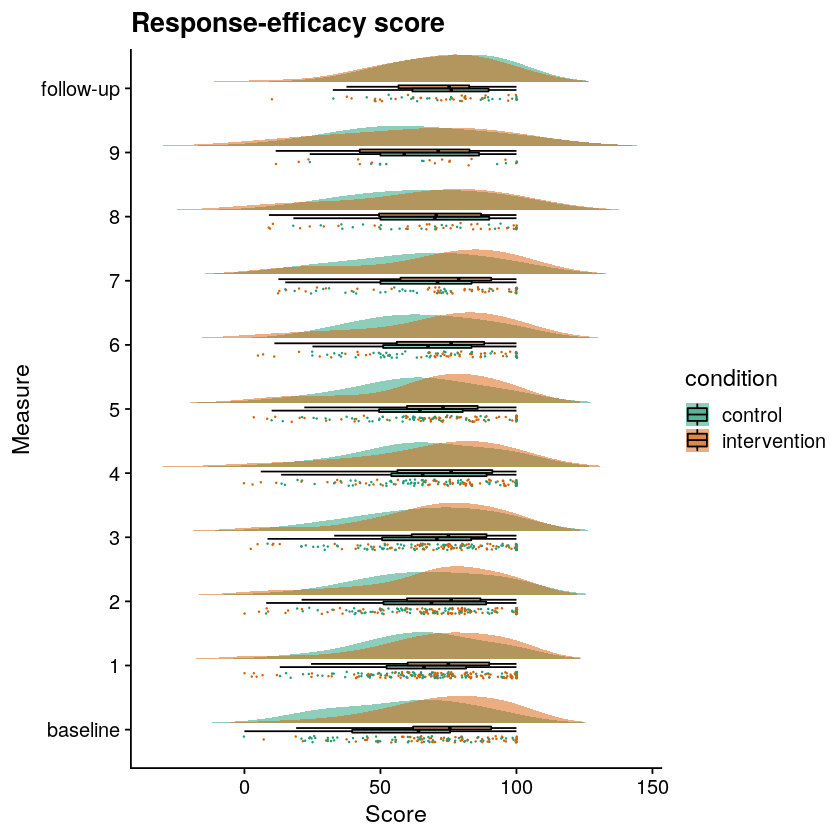

In [61]:
ggplot(df3, aes(x = n_day, y = mean_re, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = mean_re, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = mean_re,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  #scale_colour_manual(values=cbPalette)+
  #scale_fill_manual(values=cbPalette)+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Response-efficacy score") +
  coord_flip()

ggsave('raincloud_resp_eff_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
ggplot(df3, aes(x = n_day, y = mean_hope, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = mean_hope, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = mean_hope,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Hope score") +
  coord_flip()

ggsave('raincloud_hope_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
colnames(df3)